**CNN Implementation using Pytorch**

Files already downloaded and verified
Files already downloaded and verified


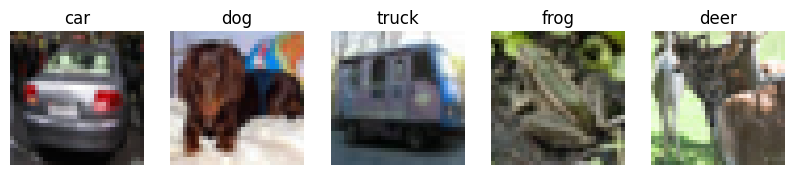

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                  [-1, 256]         262,400
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
            Linear-8                   [-1, 10]           1,290
Total params: 297,978
Trainable params: 297,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 1.14
Estimated Total Size (MB): 1.27
----------------------------------------------------------------
[1, 200] loss: 2.151
[1, 400] loss: 1.883


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) #16,16,8
        x = self.pool(torch.relu(self.conv2(x))) #8,8,16
        x = x.view(-1, 16 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Show random images from trainset
def show_random_images(trainset):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for ax in axes:
        idx = np.random.randint(len(trainset))
        img, label = trainset[idx]
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0))) #(C,H,W) -> (H,W,C)
        ax.set_title(classes[label])
        ax.axis('off')
    plt.show()

# Load and preprocess the CIFAR-10 dataset
def load_data(batch_size=64, val_split=0.1):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    val_size = int(len(trainset) * val_split)
    train_size = len(trainset) - val_size
    trainset, valset = random_split(trainset, [train_size, val_size])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, valloader, testloader, trainset

# Define the training loop
def train_model(model, trainloader, valloader, criterion, optimizer, epochs=10):
    model.train()
    train_loss_list =[]
    val_loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loss += loss.item()
            if i % 200 == 199:    # Print every 200 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
                running_loss = 0.0

        # Calculate validation loss
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for val_data in valloader:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        val_loss /= len(valloader)
        train_loss /= len(trainloader)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}")
        model.train()
    print('-------------------------- Training is completed --------------------------')
    return train_loss_list, val_loss_list

# Define the test loop
def test_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')
    print(f'Average test loss: {test_loss / len(testloader):.3f}')

# Main function to run everything
def main():
    trainloader, valloader, testloader, trainset = load_data(batch_size=32, val_split=0.1)
    show_random_images(trainset)

    model = CNN().to(device)
    summary(model, (3, 32, 32))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss_list, val_loss_list = train_model(model, trainloader, valloader, criterion, optimizer, epochs=20)

    test_model(model, testloader, criterion)

if __name__ == "__main__":
    main()